In [1]:
import gymnasium as gym 
import torch, random
from torch import optim
import numpy as np
import torch.nn as nn 
from collections import deque
import typing
import matplotlib.pyplot as plt
import math
import itertools

In [51]:
## BASE LINE DQN 
lossfunc = nn.MSELoss()
class SimpleDQN(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim), 
            nn.Sigmoid(), 
            nn.Linear(hidden_dim, action_dim)
        )
    def forward(self, x):
        return self.net(x)

class ReplayBuffer:
    def __init__(self, capacity = 1000000):
        self.buffer = deque(maxlen = capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states, dtype=np.float32),
                np.array(actions, dtype=np.int32),
                np.array(rewards, dtype=np.float32),
                np.array(next_states, dtype=np.float32),
                np.array(dones, dtype=np.uint8))
    def __len__(self):
        return len(self.buffer)


def select_action_eps_greedy(state, q_network, epsilon):
    if random.random() < epsilon:
        return random.randint(0,action_dim-1)
    else:
        state_t = torch.FloatTensor(obs).unsqueeze(0)
        with torch.no_grad():
            q_values = q_network(state_t)
        return q_values.argmax().item()

def compute_td_loss(batch , q_network, target_netork, optmizer):
    states, actions, rewards, next_states, dones = batch
    
    states_t = torch.FloatTensor(states)
    actions_t = torch.LongTensor(actions).unsqueeze(-1)
    rewards_t = torch.FloatTensor(rewards).unsqueeze(-1)
    next_states_t = torch.FloatTensor(next_states)
    dones_t = torch.FloatTensor(dones).unsqueeze(-1)
    
    current_q_values = q_network(states_t).gather(1, actions_t)
    
    with torch.no_grad():
        next_q_values = target_network(next_states_t).max(dim=1, keepdim=True)[0]
    
    expected_q_values = rewards_t + GAMMA * next_q_values * (1 - dones_t)
    loss = lossfunc(current_q_values, expected_q_values)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()
    
    
    
def action_array(action, action_dim):
    x = np.zeros(action_dim)
    x[action] = 1
    return x

def soft_update(target, online, tau):
    for target_param, online_param in zip(target.parameters(), online.parameters()):
        target_param.data.copy_(tau * online_param.data + (1.0 - tau) * target_param.data)

def hard_target_update(main, target):
    target.load_state_dict(main.state_dict())

def plot_rewards(reward_dict):
    plt.figure(figsize=(10, 6))
    for algoname, reward_list in reward_dict.items():
        plt.plot(reward_list, label=algoname)
    
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.title("Rewards over Episodes")
    plt.legend()
    plt.grid(True)
    plt.show()



def plot_improved_rewards(reward_dict, smoothing_window=10, game="GAME NAME"):
    plt.figure(figsize=(12, 6))
    
    for algoname, reward_list in reward_dict.items():
        smoothed = np.convolve(reward_list, np.ones(smoothing_window)/smoothing_window, mode='valid')
        plt.plot(smoothed, label=algoname, linewidth=2)

    plt.xlabel("Episodes", fontsize=14)
    plt.ylabel("Rewards", fontsize=14)
    plt.title(f"{game} Rewards Over Episodes (Smoothed)", fontsize=16)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    
    # Generate filename with current date and time
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{game}_rewards_plot_{current_time}.png"
    
    # Save the plot as an image file
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Plot saved as: {filename}")
    
    plt.show()


In [52]:
import gymnasium as gym
import ale_py

gym.register_envs(ale_py)

In [12]:
env = gym.make("LunarLander-v3")
#env = gym.make("HalfCheetah-v5")


In [13]:

for i in range(5):
    print(env.action_space.sample())

0
1
2
2
2


In [53]:
LR = 0.001
BUFFERSIZE = 100000
EPSILON = 0.1
MIN_REPLAY = 1000
GAMMA = 0.9

env = gym.make("LunarLander-v3")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

## Simple DQN

In [182]:


q_network = SimpleDQN(state_dim = state_dim, action_dim = action_dim)

target_network = SimpleDQN(state_dim = state_dim, action_dim = action_dim)
hard_target_update(q_network, target_network)

optimizer = torch.optim.Adam(q_network.parameters(), lr=LR)
replay_buffer = ReplayBuffer(BUFFERSIZE) 

obs, info = env.reset()
for _ in range(MIN_REPLAY):
    action = random.randint(0,action_dim-1)
    next_obs, reward, terminated, truncated, info = env.step(action_array(action, action_dim= action_dim))
    done = terminated or truncated
    replay_buffer.push(obs, action, reward, next_obs, done)

    obs = next_obs
    if done:
        obs, info = env.reset()
DQN_rewards = []
for episode in range(100):
    obs, info = env.reset()
    episode_reward = 0

    for step in range(1000):
        action = select_action_eps_greedy(obs, q_network, EPSILON, env)
        next_obs, reward, terminated, truncated, info = env.step(action_array(action, action_dim))
        done = terminated or truncated
        episode_reward += reward
        replay_buffer.push(obs, action, reward, next_obs, done)
        obs = next_obs
        batch = replay_buffer.sample(1000)
        loss = compute_td_loss(batch, q_network, target_network, optimizer)
        soft_update(target_network, q_network, 0.005)

        if done:
            break
    

    q_network.rewards.append(episode_reward)

    print(f"Episode {episode}, Rereward: {episode_reward}")
        

Episode 0, Rereward: -59.647638694493
Episode 1, Rereward: -50.762611067053804
Episode 2, Rereward: -77.14819004056052
Episode 3, Rereward: -21.33717043372063
Episode 4, Rereward: 505.97879910538114
Episode 5, Rereward: 189.63928733540305
Episode 6, Rereward: 197.67041162096425
Episode 7, Rereward: 183.12857076511986
Episode 8, Rereward: 212.14662781808988
Episode 9, Rereward: 439.6102787180236
Episode 10, Rereward: 589.6364001146535
Episode 11, Rereward: 250.46674714522385
Episode 12, Rereward: 573.4155010937111
Episode 13, Rereward: 326.8053642486323
Episode 14, Rereward: 318.1490207027914
Episode 15, Rereward: 343.76144912343045
Episode 16, Rereward: 565.9902861227777
Episode 17, Rereward: 361.07738823653386
Episode 18, Rereward: 302.20298248405965
Episode 19, Rereward: 411.12243179596663
Episode 20, Rereward: 328.88188595731583
Episode 21, Rereward: 295.46367637510724
Episode 22, Rereward: 291.96034139843
Episode 23, Rereward: 404.6978594254981
Episode 24, Rereward: 297.07383544886

In [183]:
simple_dqn_rewards = q_network.rewards

In [13]:
class MeanVarianceQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU()
        )
        # Mean head
        self.mean_head = nn.Linear(hidden_dim, action_dim)
        # Log-variance head
        self.logvar_head = nn.Linear(hidden_dim, action_dim)
        self.rewards = []
        
    def forward(self, state):
        """
        Returns mean-Q(s) and log-var-Q(s) for each discrete action.
        state: [batch_size, state_dim]
        """
        features = self.shared(state)
        mean = self.mean_head(features)
        logvar = self.logvar_head(features)
        return mean, logvar


def select_action_eps_greedy_meanvarQnet(state, q_network, epsilon):
    if random.random() < epsilon:
        return random.randint(0, action_dim - 1)
    else:
        state_t = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            mean, logvar = q_network(state_t)
        return mean.squeeze().argmax().item()

def selection_action_logvar(state, q_network, beta = 1):
    state_t = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
        mean, logvar = q_network(state_t)
    q_values = mean + beta * logvar
    return q_values.argmax().item()

def select_action_uncertainty_aware(state, q_network, beta = 1):
    state_t = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
        mean, logvar = q_network(state_t)
        variance = torch.exp(logvar)
    q_values = mean + beta * torch.sqrt(variance)
    
    return q_values.argmax().item()


In [184]:
def distributional_wasserstein_2_sq_td_loss(batch, q_network, target_network, optimizer):
    states, actions, rewards, next_states, dones = batch
    
    states_t = torch.FloatTensor(states)
    actions_t = torch.LongTensor(actions).unsqueeze(-1)
    rewards_t = torch.FloatTensor(rewards).unsqueeze(-1)
    next_states_t = torch.FloatTensor(next_states)
    dones_t = torch.FloatTensor(dones).unsqueeze(-1)
    
    mean, logvar = q_network(states_t)  
    mean_taken = mean.gather(1, actions_t)      
    logvar_taken = logvar.gather(1, actions_t)   
    var_taken = torch.exp(logvar_taken)
    
    with torch.no_grad():
        next_mean, next_logvar = target_network(next_states_t)
        next_mean_max = next_mean.max(dim=1, keepdim=True)[0]  
        td_target = rewards_t + GAMMA * next_mean_max * (1 - dones_t) 

    diff = mean_taken - td_target
    wasserstein_2_sq = diff.pow(2) + var_taken

    loss = wasserstein_2_sq.mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()
def distributional_kl_gaussian_td_loss(
    batch,
    q_network,
    target_network,
    optimizer,
    gamma=0.99
):

    states, actions, rewards, next_states, dones = batch

    states_t = torch.FloatTensor(states)
    actions_t = torch.LongTensor(actions).unsqueeze(-1)
    rewards_t = torch.FloatTensor(rewards).unsqueeze(-1)
    next_states_t = torch.FloatTensor(next_states)
    dones_t = torch.FloatTensor(dones).unsqueeze(-1)

    mean, logvar = q_network(states_t)
    mean_taken = mean.gather(1, actions_t)
    logvar_taken = logvar.gather(1, actions_t)
    var_taken = torch.exp(logvar_taken)

    with torch.no_grad():
        next_mean, next_logvar = target_network(next_states_t)
        next_mean_max = next_mean.max(dim=1, keepdim=True)[0]
        td_target = rewards_t + gamma * next_mean_max * (1 - dones_t)

    # KL( δ(td_target) || N(mean, var) ) 
    #   = - log Normal(td_target | mean, var)
    #   = 0.5 * log(2π var) + ((td_target - mean)^2) / (2 var)
    # We'll average over the batch
    diff_sq = (td_target - mean_taken).pow(2)
    kl = 0.5 * (logvar_taken + np.log(2*np.pi)) + diff_sq / (2 * var_taken)

    loss = kl.mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

In [190]:
q_network = MeanVarianceQNetwork(state_dim, action_dim)
target_network = MeanVarianceQNetwork(state_dim, action_dim)
target_network.load_state_dict(q_network.state_dict())

optimizer = optim.Adam(q_network.parameters(), lr=LR)
buffer = ReplayBuffer(capacity=100000)

epsilon = 0.1

state, info = env.reset()
for _ in range(MIN_REPLAY):
    action = random.randint(0,action_dim-1)
    next_obs, reward, terminated, truncated, info = env.step(action_array(action, action_dim= action_dim))
    done = terminated or truncated
    buffer.push(obs, action, reward, next_obs, done)

    obs = next_obs
    if done:
        obs, info = env.reset()

logvar_beta_1 = []
for episode in range(100):
    state, info = env.reset()
    done = False
    episode_reward = 0
    steps = 0
    
    for i in range(1000):
        #action = select_action_eps_greedy_meanvarQnet(state, q_network, epsilon)
        action = select_action_uncertainty_aware(state, q_network, beta = 0.1)
        next_state, reward, done, truncated,  info = env.step(action_array(action, action_dim=action_dim))
        buffer.push(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward
        steps += 1

        # Learn
        
        batch_data = buffer.sample(10)
        loss = distributional_kl_gaussian_td_loss(batch_data, q_network, target_network, optimizer)
        soft_update(target_network, q_network, 0.005)
        # Update target network
        if done: break
    logvar_beta_1.append(episode_reward)
    
        

    print(f"Episode {episode}, reward={episode_reward:.2f}")

env.close()

Episode 0, reward=-74.17
Episode 1, reward=-350.42
Episode 2, reward=-223.38
Episode 3, reward=-121.61
Episode 4, reward=-113.09
Episode 5, reward=-95.24
Episode 6, reward=-76.67
Episode 7, reward=-48.68
Episode 8, reward=29.72
Episode 9, reward=101.34
Episode 10, reward=121.77
Episode 11, reward=142.90
Episode 12, reward=168.91
Episode 13, reward=161.91
Episode 14, reward=162.04
Episode 15, reward=212.00
Episode 16, reward=210.66
Episode 17, reward=234.02
Episode 18, reward=231.48
Episode 19, reward=227.00
Episode 20, reward=253.85
Episode 21, reward=261.35
Episode 22, reward=284.01
Episode 23, reward=258.30
Episode 24, reward=258.78
Episode 25, reward=280.25
Episode 26, reward=265.30
Episode 27, reward=291.74
Episode 28, reward=271.48
Episode 29, reward=275.54
Episode 30, reward=303.79
Episode 31, reward=295.54
Episode 32, reward=296.02
Episode 33, reward=317.48
Episode 34, reward=287.11
Episode 35, reward=340.57
Episode 36, reward=323.63
Episode 37, reward=327.09
Episode 38, reward=

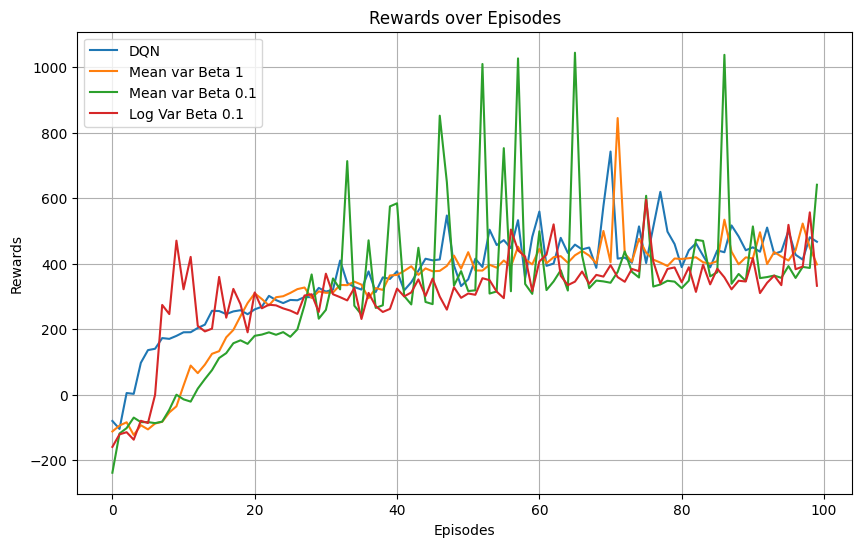

In [415]:
plot_rewards({"DQN":DQN_rewards, "Mean var Beta 1":meanvar_beta_1[:100], "Mean var Beta 0.1":meanvar_beta_01[:100], "Log Var Beta 0.1": logvar_beta_1})

In [189]:
for episode in range(1000):
    state, info = env.reset()
    done = False
    episode_reward = 0
    steps = 0
    
    for i in range(1000):
        #action = select_action_eps_greedy_meanvarQnet(state, q_network, epsilon)
        action = select_action_uncertainty_aware(state, q_network, beta = 0)
        next_state, reward, done, truncated,  info = env.step(action_array(action, action_dim=action_dim))
        buffer.push(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward
        steps += 1

        # Learn
        
        batch_data = buffer.sample(10)
        loss = distributional_wasserstein_2_sq_td_loss(batch_data, q_network, target_network, optimizer)
        # Update target network
        if steps % 1000 == 0:
            target_network.load_state_dict(q_network.state_dict())
        if done: 
            break

    print(f"Episode {episode}, reward={episode_reward:.2f}")

Episode 0, reward=471.55
Episode 1, reward=95.73
Episode 2, reward=109.40
Episode 3, reward=53.82
Episode 4, reward=-46.63
Episode 5, reward=-62.62
Episode 6, reward=-47.87
Episode 7, reward=0.93
Episode 8, reward=-7.34
Episode 9, reward=-13.69
Episode 10, reward=-60.38
Episode 11, reward=-10.89
Episode 12, reward=15.74
Episode 13, reward=247.94
Episode 14, reward=37.81
Episode 15, reward=-65.15
Episode 16, reward=-51.17
Episode 17, reward=-27.59
Episode 18, reward=-42.75
Episode 19, reward=15.63
Episode 20, reward=57.92
Episode 21, reward=44.98
Episode 22, reward=40.27
Episode 23, reward=-54.83
Episode 24, reward=94.28
Episode 25, reward=67.06


KeyboardInterrupt: 

## Actor Critic

In [4]:
class GaussianPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, hidde_dim = 128):
        super().__init__()
        self.net = nn.Sequential(
        nn.Linear(state_dim, hidden_dim), 
        nn.ReLU(), 
        nn.Linear(hidden_dim, hidden_dim), 
        nn.ReLU()
        )

        self.mu_head = nn.Linear(hidden_dim, action_dim)
        self.log_sigma_head = nn.Linear(hidden_dim, action_dim)
    def forward(self, state):
        features = self.net(state)
        mu = self.mu_head(features)
        log_sigma = torch.clamp(self.log_sigma_head(features), -20, 2)
        return mu, log_sigma

class DeterministicActor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Tanh()  
        )
    
    def forward(self, state):
        return self.net(state)

class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidde_dim = 128):
        super().__init__()
        self.net = nn.Sequential(
        nn.Linear(state_dim, hidden_dim), 
        nn.ReLU(), 
        nn.Linear(hidden_dim, hidden_dim), 
        nn.ReLU(), 
        nn.LInear(hidden_dim, 1)
        )
    def forward(self, state):
        self.net(state)
        

class ActionValueNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidde_dim = 128):
        super().__init__()
        self.net = nn.Sequential(
        nn.Linear(state_dim+action_dim, hidden_dim), 
        nn.ReLU(), 
        nn.Linear(hidden_dim, hidden_dim), 
        nn.ReLU(), 
        nn.LInear(hidden_dim, 1)
        )
         
    def forward(self, state, action):
        return self.net(torch.cat([state, action]))
    
        

In [ ]:


def update_actor_critic_determenistic(policy: DeterministicActor, actorvaluenet: ActionValueNetwork, batch,  optimizer_policy, optimizer_value):

    states, actions, rewards, next_states, dones = batch
    
    states_t = torch.FloatTensor(states)
    actions_t = torch.LongTensor(actions).unsqueeze(-1)
    rewards_t = torch.FloatTensor(rewards).unsqueeze(-1)
    next_states_t = torch.FloatTensor(next_states)
    dones_t = torch.FloatTensor(dones).unsqueeze(-1)

    vals = actorvaluenet(states_t)               
    with torch.no_grad():
        next_vals = actorvaluenet(next_states_t)    
        td_target = rewards_t + GAMMA * next_vals * (1 - dones_t)

    value_loss = nn.MSELoss()(vals, td_target.detach())

    optimizer_value.zero_grad()
    value_loss.backward()
    optimizer_value.step()

    actor_loss = actor(states_t)
    loss = -value(
    
    
    

In [18]:
try: del utils
except: pass
from utils import *

In [118]:
class GaussianCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU()
        )
        self.mu_head = nn.Linear(hidden_dim, 1)
        self.log_sigma_head = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32)
        if not isinstance(action, torch.Tensor):
            action = torch.tensor(action, dtype=torch.float32)

        x = torch.cat([state, action], dim=-1)  # Concatenates along feature dim
        features = self.net(x)
        
        mu = self.mu_head(features)  # Mean Q-value
        log_sigma = torch.clamp(self.log_sigma_head(features), -20, 2)  # Clamp log variance
        
        return mu, log_sigma

class GaussianEnsembleCritic(nn.Module):
    def __init__(self, state_dim, action_dim, num_critics=5, hidden_dim=256):
        super().__init__()
        self.num_critics = num_critics
        self.critics = nn.ModuleList([
            GaussianCritic(state_dim, action_dim, hidden_dim) 
            for _ in range(num_critics)
        ])
    
    def forward(self, state, action):
        q_outputs = [critic(state, action) for critic in self.critics]
        mus, log_vars = zip(*q_outputs)  # Extract means and log variances separately
        mus = torch.stack(mus, dim=0)  # Shape: [num_critics, batch_size, 1]
        log_vars = torch.stack(log_vars, dim=0)
        return mus, log_vars

def compute_uncertainty(q_means, q_log_vars):
    q_variances = torch.exp(q_log_vars)
    mean_q = q_means.mean(dim=0)
    epistemic_uncertainty = ((q_means - mean_q) ** 2).mean(dim=0)
    aleatoric_uncertainty = q_variances.mean(dim=0)
    return epistemic_uncertainty, aleatoric_uncertainty

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Tanh()
        )
    
    def forward(self, state):
        return self.net(state)



In [159]:
env_name="HalfCheetah-v5"
num_episodes=500
batch_size=64
gamma=0.99
tau=0.005
lr=1e-3
num_critics=5
exploration_beta =  0.1

global_step = 0
steps_per_update = 100

env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

critics = GaussianEnsembleCritic(state_dim, action_dim, hidden_dim= 128, num_critics= 5)
target_critics = GaussianEnsembleCritic(state_dim, action_dim, hidden_dim= 128, num_critics= 5)
hard_target_update(main=critics, target= target_critics)
critic_optimizers = [optim.Adam(critic.parameters(), lr=lr) for critic in critics.critics]

actor = Actor(state_dim, action_dim, hidden_dim= 128)
actor_optimizer = optim.Adam(actor.parameters(), lr=lr)
target_actor = Actor(state_dim, action_dim, hidden_dim= 128)
hard_target_update(actor, target_actor)

buffer = ReplayBuffer()

In [160]:
for i in range(10000):
    state, info = env.reset()
    episode_reward = 0
    state_t = torch.FloatTensor(state).unsqueeze(0)  # shape [1, state_dim]
    with torch.no_grad():
        action = actor(state_t).cpu().numpy()[0]  # deterministic policy
    # Add exploration noise
    action = action + np.random.normal(0, exploration_noise_std, size=action_dim)
    action = np.clip(action, env.action_space.low, env.action_space.high)
    next_state, reward, done, truncated, _ = env.step(action)
    buffer.push(state, action, reward,  next_state, done)
    state = next_state
    episode_reward += reward

In [161]:
states, actions, rewards, next_states, dones = buffer.sample(batch_size)
states_t = torch.FloatTensor(states)
actions_t = torch.FloatTensor(actions)
rewards_t = torch.FloatTensor(rewards)
next_states_t = torch.FloatTensor(next_states)
dones_t = torch.FloatTensor(dones)

In [117]:
states_t.size(), actions_t.size()

(torch.Size([64, 17]), torch.Size([64, 6]))

In [105]:
target_critics.critics

ModuleList(
  (0-4): 5 x GaussianCritic(
    (net): Sequential(
      (0): Linear(in_features=23, out_features=256, bias=True)
      (1): ReLU()
    )
    (mu_head): Linear(in_features=256, out_features=1, bias=True)
    (log_sigma_head): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [122]:
target_critics(next_states_t, next_actions)

(tensor([[[-1.9250e-02],
          [-3.4454e-02],
          [ 1.5199e-02],
          [ 4.9651e-02],
          [ 2.1841e-02],
          [ 1.3418e-02],
          [ 4.4633e-03],
          [-7.5839e-02],
          [ 2.9543e-02],
          [ 5.5667e-02],
          [-1.5686e-03],
          [-1.1877e-01],
          [-5.2035e-02],
          [-3.4516e-02],
          [-3.1603e-03],
          [-2.9603e-02],
          [-8.9471e-02],
          [ 1.1592e-02],
          [ 9.3563e-03],
          [ 6.5614e-03],
          [-5.1534e-03],
          [ 2.8078e-02],
          [-1.5277e-02],
          [-2.8161e-03],
          [ 9.4759e-03],
          [-5.6259e-02],
          [-1.1210e-03],
          [ 2.9438e-02],
          [-4.3299e-03],
          [-6.2351e-02],
          [-9.3713e-02],
          [ 2.3368e-02],
          [ 8.4611e-03],
          [ 6.0271e-02],
          [ 2.8408e-02],
          [-4.2975e-02],
          [-3.4614e-02],
          [-6.5648e-02],
          [ 7.2138e-03],
          [ 3.0048e-02],


In [165]:
use_exploration_bonus = False
risk_averse = False

In [168]:
for ep in range(num_episodes):
    state, info = env.reset()
    episode_reward = 0
    done = False
    cur = 0 
    while not done and cur < 1000:
        cur += 1 
        global_step += 1
        state_t = torch.FloatTensor(state).unsqueeze(0)  # shape [1, state_dim]
        with torch.no_grad():
            action = actor(state_t).cpu().numpy()[0]  # deterministic policy
        # Add exploration noise
        action = action + np.random.normal(0, exploration_noise_std, size=action_dim)
        action = np.clip(action, env.action_space.low, env.action_space.high)
        next_state, reward, done, truncated, _ = env.step(action)
        buffer.push(state, action, reward,  next_state, done)
        state = next_state
        episode_reward += reward

        # Training step
        if len(buffer.buffer) >= batch_size and (global_step % steps_per_update == 0):
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)
            states_t = torch.FloatTensor(states)
            actions_t = torch.FloatTensor(actions)
            rewards_t = torch.FloatTensor(rewards)
            next_states_t = torch.FloatTensor(next_states)
            dones_t = torch.FloatTensor(dones)

            # ---- Critic Update ----
            with torch.no_grad():
                next_actions = target_actor(next_states_t)
                t_mus, t_log_vars = target_critics(next_states_t, next_actions)
                # We only use the means for the target (TD3 style min of ensemble)
                # shape [num_critics, batch_size, 1]
                t_mus_min = t_mus.mean(dim=0)[0]  # [batch_size, 1]
                # Optional expansions:
                # t_mus_mean = t_mus.mean(dim=0)[0]

                # If using exploration bonus, incorporate epistemic uncertainty
                if use_exploration_bonus or risk_averse:
                    # Compute uncertainties from target critics
                    ep_uncert, al_uncert = compute_uncertainty(t_mus, t_log_vars)
                    # exploration bonus: + beta * ep_uncert
                    if use_exploration_bonus:
                        reward_bonus = exploration_beta * ep_uncert
                    else:
                        reward_bonus = 0

                    # risk penalty: - alpha * ep_uncert
                    if risk_averse:
                        # negative shaping
                        penalty = risk_penalty * ep_uncert
                    else:
                        penalty = 0

                    y = rewards_t + reward_bonus - penalty + gamma * (1 - dones_t) * t_mus_min
                else:
                    # Standard TD3
                    y = rewards_t + gamma * (1 - dones_t) * t_mus_min

            # Each critic in the main ensemble
            for i, critic in enumerate(critics.critics):
                mu_pred, log_var_pred = critic(states_t, actions_t)
                sigma_pred = torch.exp(log_var_pred)
                diff = mu_pred - y
                # distributional loss: (mu-y)^2 + sigma^2
                loss = (diff ** 2 + sigma_pred).mean()

                critic_optimizers[i].zero_grad()
                loss.backward()
                critic_optimizers[i].step()

            # ---- Actor Update ----
            # We want to maximize min_critic_mu for the current critics
            curr_actions = actor(states_t)
            
            mus, _ = critics(states_t, curr_actions)
            min_q = mus.min(dim=0)[0]  # [batch_size, 1]

            actor_loss = -(min_q.mean())
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            # ---- Soft update target networks ----
            soft_update(critics, target_critics, tau)
            soft_update(actor, target_actor, tau)

    print(f"Episode {ep+1}: Reward = {episode_reward:.2f}")

env.close()

Episode 1: Reward = -369.50
Episode 2: Reward = -336.53
Episode 3: Reward = -445.99
Episode 4: Reward = -476.81
Episode 5: Reward = -382.21
Episode 6: Reward = -449.53
Episode 7: Reward = -444.43
Episode 8: Reward = -228.75
Episode 9: Reward = -195.60
Episode 10: Reward = -215.10
Episode 11: Reward = 52.38
Episode 12: Reward = -122.00
Episode 13: Reward = -188.70
Episode 14: Reward = -83.12
Episode 15: Reward = 20.41
Episode 16: Reward = -195.01
Episode 17: Reward = -385.60
Episode 18: Reward = -141.93
Episode 19: Reward = -125.49
Episode 20: Reward = -111.13
Episode 21: Reward = -794.87
Episode 22: Reward = -380.82
Episode 23: Reward = 2.77
Episode 24: Reward = -73.27
Episode 25: Reward = -318.36
Episode 26: Reward = -214.50
Episode 27: Reward = -79.05
Episode 28: Reward = -119.43
Episode 29: Reward = -261.38
Episode 30: Reward = -328.27
Episode 31: Reward = -41.82
Episode 32: Reward = -207.12
Episode 33: Reward = -297.55
Episode 34: Reward = -212.12
Episode 35: Reward = -249.80
Episo

## Ensemble Actor

In [6]:
class EnsembleDQN(nn.Module):
    def __init__(self, state_dim, action_dim, num_ensemble=5, hidden_dim=128):
        super().__init__()
        self.num_ensemble = num_ensemble
        self.qnets = nn.ModuleList([SimpleDQN(state_dim, action_dim, hidden_dim) 
                                    for _ in range(num_ensemble)])
        self.possibility = [1.0 for _ in range(num_ensemble)]
    
    def forward(self, state):
        return [qnet(state) for qnet in self.qnets]

In [7]:
def select_action_weighted_sum(state, ensemble_actor, epsilon, action_dim):
    """
    Method 1: Weighted Sum / Weighted Average of Q-values.
    
    Each ensemble member's Q-values is weighted by its (normalized) possibility.
    The final action is chosen as the argmax of the aggregated Q-values.
    """
    if random.random() < epsilon:
        return random.randint(0, action_dim - 1)
    else:
        state_t = torch.FloatTensor(state).unsqueeze(0)
        q_values_list = [qnet(state_t) for qnet in ensemble_actor.qnets]
        poss = np.array(ensemble_actor.possibility)
        poss_normalized = poss / poss.sum()
        # Weighted aggregation of Q-values:
        weighted_q_values = sum(p * q for p, q in zip(poss_normalized, q_values_list))
        return weighted_q_values.argmax().item()


def select_action_majority_vote(state, ensemble_actor, epsilon, action_dim):
    """
    Method 2: Majority Voting.
    
    Each ensemble member votes for its best action.
    Votes are weighted by the possibility of each member.
    The final action is the one that accumulates the highest vote sum.
    """
    if random.random() < epsilon:
        return random.randint(0, action_dim - 1)
    else:
        state_t = torch.FloatTensor(state).unsqueeze(0)
        votes = np.zeros(action_dim)
        for i, qnet in enumerate(ensemble_actor.qnets):
            q_values = qnet(state_t)
            best_action = q_values.argmax().item()
            votes[best_action] += ensemble_actor.possibility[i]
        return int(np.argmax(votes))


def select_action_max_possibility(state, ensemble_actor, epsilon, action_dim):
    """
    Method 3: Maximum Possibility Selection.
    
    Only the ensemble member with the highest possibility is used to select the action.

    this makes sense with the average approach maybe? 
    """
    if random.random() < epsilon:
        return random.randint(0, action_dim - 1)
    else:
        state_t = torch.FloatTensor(state).unsqueeze(0)
        max_idx = np.argmax(ensemble_actor.possibility)
        q_values = ensemble_actor.qnets[max_idx](state_t)
        return q_values.argmax().item()


def select_action_softmax(state, ensemble_actor, epsilon, action_dim, temperature=1.0):
    """
    Method 4: Softmax (Boltzmann) Exploration over Actions.
    
    First, a weighted sum of Q-values is computed (like in method 1).
    Then, the resulting Q-values are converted into a probability distribution using softmax with temperature scaling.
    Finally, an action is sampled from this distribution.
    """
    if random.random() < epsilon:
        return random.randint(0, action_dim - 1)
    else:
        state_t = torch.FloatTensor(state).unsqueeze(0)
        q_values_list = [qnet(state_t) for qnet in ensemble_actor.qnets]
        poss = np.array(ensemble_actor.possibility)
        poss_normalized = poss / poss.sum()
        weighted_q_values = sum(p * q for p, q in zip(poss_normalized, q_values_list))
        q_values = weighted_q_values.squeeze(0)  # Remove the batch dimension
        # Apply softmax with temperature scaling:
        probs = torch.softmax(q_values / temperature, dim=0)
        action = torch.multinomial(probs, num_samples=1).item()
        return action

In [131]:
def compute_td_loss_ensemble2(batch, ensemble_actor, target_ensemble, optimizers, alpha=0.2, beta=0.01):

    states, actions, rewards, next_states, dones = batch

    states_t = torch.FloatTensor(states)
    actions_t = torch.LongTensor(actions).unsqueeze(-1)
    rewards_t = torch.FloatTensor(rewards).unsqueeze(-1)
    next_states_t = torch.FloatTensor(next_states)
    dones_t = torch.FloatTensor(dones).unsqueeze(-1)

    losses = []
    candidate_poss = []
    
    # For each ensemble member, compute the TD loss and update the network and possibility.
    
        
    for i, qnet in enumerate(ensemble_actor.qnets):
        optimizer = optimizers[i]
        
        # Compute current Q-values for the taken actions.
        current_q_values = qnet(states_t).gather(1, actions_t)

            # Each ensemble member has its own target network.
            
        with torch.no_grad():
            next_q_values = target_ensemble.qnets[i](next_states_t).max(dim=1, keepdim=True)[0] 
            
        expected_q_values = rewards_t + GAMMA * next_q_values * (1 - dones_t)
        loss = lossfunc(current_q_values, expected_q_values)
        losses.append(loss.item())
        
        # Zero the gradients, backpropagate, and compute gradient norm.
        optimizer.zero_grad()
        loss.backward()
        
        grad_norm = 0.0
        for param in qnet.parameters():
            if param.grad is not None:
                grad_norm += param.grad.data.norm(2).item() ** 2
        grad_norm = math.sqrt(grad_norm)
        
        # Compute candidate possibility: lower loss and smaller grad_norm yield a higher candidate.
        candidate = math.exp(-loss.item() - beta * grad_norm)
        candidate_poss.append(candidate)
        
        # Take the optimizer step.
        optimizer.step()
    
    # Update possibility for each ensemble member using an EMA update.
    for i in range(ensemble_actor.num_ensemble):
        ensemble_actor.possibility[i] = (1 - alpha) * ensemble_actor.possibility[i] + alpha * candidate_poss[i]
    
    # Optionally, re-normalize the possibilities so that they sum to 1.
    total = sum(ensemble_actor.possibility)
    ensemble_actor.possibility = [p / total for p in ensemble_actor.possibility]
    
    return losses, candidate_poss


def select_action_majority_vote(state, ensemble_actor, epsilon, action_dim):
    """
    Method 2: Majority Voting.
    
    Each ensemble member votes for its best action.
    Votes are weighted by the possibility of each member.
    The final action is the one that accumulates the highest vote sum.
    """
    if random.random() < epsilon:
        return random.randint(0, action_dim - 1)
    else:
        state_t = torch.FloatTensor(state).unsqueeze(0)
        votes = np.zeros(action_dim)
        for i, qnet in enumerate(ensemble_actor.qnets):
            q_values = qnet(state_t)
            best_action = q_values.argmax().item()
            votes[best_action] += ensemble_actor.possibility[i]
        return int(np.argmax(votes))

##these both together seem to perform incredibly well 

In [153]:

import torch.nn.functional as F
def compute_td_loss_ensemble(batch, ensemble_actor, target_ensemble, optimizers):

    ## The possiblity jsut goes to zero so changes
    states, actions, rewards, next_states, dones = batch

    states_t = torch.FloatTensor(states)
    actions_t = torch.LongTensor(actions).unsqueeze(-1)
    rewards_t = torch.FloatTensor(rewards).unsqueeze(-1)
    next_states_t = torch.FloatTensor(next_states)
    dones_t = torch.FloatTensor(dones).unsqueeze(-1)
    
    losses = []
    likelihoods = []
    
    #print(compute_average_cosine_similarity_batch(ensemble_actor, states))
    
    # For each ensemble member, compute the TD loss and perform an optimizer step.
    for i, qnet in enumerate(ensemble_actor.qnets):
        optimizer = optimizers[i]
        
        # Current Q-values for chosen actions
        current_q_values = qnet(states_t).gather(1, actions_t)
        with torch.no_grad():
            next_q_values = target_ensemble.qnets[i](next_states_t).max(dim=1, keepdim=True)[0] 
        expected_q_values = rewards_t + GAMMA * next_q_values * (1 - dones_t)
        loss = lossfunc(current_q_values, expected_q_values)
        losses.append(loss.item())
        
        likelihood = math.exp(-loss.item())
        likelihoods.append(likelihood)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
   
    
    #max_likelihood = max([likelihoods[i] * ensemble_actor.possibility[i] for i in range(len(likelihoods))])
    # for i in range(ensemble_actor.num_ensemble):
    #     ensemble_actor.possibility[i] = ensemble_actor.possibility[i] * likelihoods[i] / max_likelihood


    # avg_likelihood = sum(likelihoods) / len(likelihoods)
    # for i in range(ensemble_actor.num_ensemble):
    #     candidate = likelihoods[i] / avg_likelihood  
    #     ensemble_actor.possibility[i] = min(ensemble_actor.possibility[i]*candidate, 1)


    #model weights remain close to 1. 
    alpha = 0.2 
    avg_likelihood = sum(likelihoods) / len(likelihoods) + 0.000001
    for i in range(ensemble_actor.num_ensemble):
        candidate = likelihoods[i] / avg_likelihood  # >1 if better than average, <1 if worse
        # Update with EMA: this increases possibility if candidate > 1, and decreases if < 1
        ensemble_actor.possibility[i] = max(min((1 - alpha) * ensemble_actor.possibility[i] + alpha * candidate, 1), 0.1)
    
    # alpha = 0.1  # Smoothing factor (0 < alpha < 1)
    # avg_likelihood = sum(likelihoods) / len(likelihoods) + 0.000001
    # for i in range(ensemble_actor.num_ensemble):
    #     candidate = likelihoods[i] / avg_likelihood  # >1 if better than average, <1 if worse
    #     # Update with EMA: this increases possibility if candidate > 1, and decreases if < 1
    #     ensemble_actor.possibility[i] = max(min(ensemble_actor.possibility[i]* candidate, 1), 0.1)
    # total = sum(ensemble_actor.possibility)
    # ensemble_actor.possibility = [p / total for p in ensemble_actor.possibility]
    return np.mean(losses)

def compute_td_loss_ensemble_min(batch, ensemble_actor, target_ensemble, optimizers):

    ## The possiblity jsut goes to zero so changes
    states, actions, rewards, next_states, dones = batch

    states_t = torch.FloatTensor(states)
    actions_t = torch.LongTensor(actions).unsqueeze(-1)
    rewards_t = torch.FloatTensor(rewards).unsqueeze(-1)
    next_states_t = torch.FloatTensor(next_states)
    dones_t = torch.FloatTensor(dones).unsqueeze(-1)
    
    losses = []
    likelihoods = []
    
    #print(compute_average_cosine_similarity_batch(ensemble_actor, states))
    with torch.no_grad():
        next_q_values = torch.amin(
            torch.stack([
                target_ensemble.qnets[i](states_t).max(dim=1, keepdim=True)[0]
                for i in range(target_ensemble.num_ensemble)
            ]), dim = 0
        )
    # For each ensemble member, compute the TD loss and perform an optimizer step.
    for i, qnet in enumerate(ensemble_actor.qnets):
        optimizer = optimizers[i]
        
        # Current Q-values for chosen actions
        current_q_values = qnet(states_t).gather(1, actions_t)
  
        expected_q_values = rewards_t + GAMMA * next_q_values * (1 - dones_t)
        loss = lossfunc(current_q_values, expected_q_values)
        losses.append(loss.item())
        
        likelihood = math.exp(-loss.item())
        likelihoods.append(likelihood)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
   
    max_likelihood = max([likelihoods[i] * ensemble_actor.possibility[i] for i in range(len(likelihoods))])
    
    for i in range(ensemble_actor.num_ensemble):
        ensemble_actor.possibility[i] = max(0.9 * ensemble_actor.possibility[i],  likelihoods[i] / max_likelihood)


    # avg_likelihood = sum(likelihoods) / len(likelihoods)
    # for i in range(ensemble_actor.num_ensemble):
    #     candidate = likelihoods[i] / avg_likelihood  
    #     ensemble_actor.possibility[i] = min(ensemble_actor.possibility[i]*candidate, 1)


    # model weights remain close to 1. 
    # alpha = 0.1  # Smoothing factor (0 < alpha < 1)
    # avg_likelihood = sum(likelihoods) / len(likelihoods) + 0.000001
    # for i in range(ensemble_actor.num_ensemble):
    #     candidate = likelihoods[i] / avg_likelihood  # >1 if better than average, <1 if worse
    #     # Update with EMA: this increases possibility if candidate > 1, and decreases if < 1
    #     ensemble_actor.possibility[i] = max(min((1 - alpha) * ensemble_actor.possibility[i] + alpha * candidate, 1), 0.1)
    
    # alpha = 0.1  # Smoothing factor (0 < alpha < 1)
    # avg_likelihood = sum(likelihoods) / len(likelihoods) + 0.000001
    # for i in range(ensemble_actor.num_ensemble):
    #     candidate = likelihoods[i] / avg_likelihood  # >1 if better than average, <1 if worse
    #     # Update with EMA: this increases possibility if candidate > 1, and decreases if < 1
    #     ensemble_actor.possibility[i] = max(min(ensemble_actor.possibility[i]* candidate, 1), 0.1)
    # total = sum(ensemble_actor.possibility)
    # ensemble_actor.possibility = [p / total for p in ensemble_actor.possibility]
    return np.mean(losses)


def compute_td_loss_ensemble2(batch, ensemble_actor, target_ensemble, optimizers, alpha=0.3, beta=0.01):

    states, actions, rewards, next_states, dones = batch

    states_t = torch.FloatTensor(states)
    actions_t = torch.LongTensor(actions).unsqueeze(-1)
    rewards_t = torch.FloatTensor(rewards).unsqueeze(-1)
    next_states_t = torch.FloatTensor(next_states)
    dones_t = torch.FloatTensor(dones).unsqueeze(-1)

    losses = []
    candidate_poss = []
    
    # For each ensemble member, compute the TD loss and update the network and possibility.
    
        
    for i, qnet in enumerate(ensemble_actor.qnets):
        optimizer = optimizers[i]
        
        # Compute current Q-values for the taken actions.
        current_q_values = qnet(states_t).gather(1, actions_t)

            # Each ensemble member has its own target network.
            
        with torch.no_grad():
            next_q_values = target_ensemble.qnets[i](next_states_t).max(dim=1, keepdim=True)[0] 
            
        expected_q_values = rewards_t + GAMMA * next_q_values * (1 - dones_t)
        loss = lossfunc(current_q_values, expected_q_values)
        losses.append(loss.item())
        
        # Zero the gradients, backpropagate, and compute gradient norm.
        optimizer.zero_grad()
        loss.backward()
        
        grad_norm = 0.0
        for param in qnet.parameters():
            if param.grad is not None:
                grad_norm += param.grad.data.norm(2).item() ** 2
        grad_norm = math.sqrt(grad_norm)
        
        # Compute candidate possibility: lower loss and smaller grad_norm yield a higher candidate.
        candidate = math.exp(-loss.item() - beta * grad_norm)
        candidate_poss.append(candidate)
        
        # Take the optimizer step.
        optimizer.step()
    
    # Update possibility for each ensemble member using an EMA update.
    for i in range(ensemble_actor.num_ensemble):
        ensemble_actor.possibility[i] = (1 - alpha) * ensemble_actor.possibility[i] + alpha * candidate_poss[i]
    
    # Optionally, re-normalize the possibilities so that they sum to 1.
    total = sum(ensemble_actor.possibility)
    ensemble_actor.possibility = [p / total for p in ensemble_actor.possibility]
    
    return np.mean(losses)


In [149]:
gym.make("LunarLander-v3")

<TimeLimit<OrderEnforcing<PassiveEnvChecker<LunarLander<LunarLander-v3>>>>>

Episode: 1, Reward: -173.94
Episode: 2, Reward: -200.95
Episode: 3, Reward: -463.26
Episode: 4, Reward: -123.91
Episode: 5, Reward: -151.92
Episode: 6, Reward: -116.61
Episode: 7, Reward: -521.47
Episode: 8, Reward: -242.32
Episode: 9, Reward: -215.14
Episode: 10, Reward: -203.02
Episode: 11, Reward: -171.07
Episode: 12, Reward: -714.18
Episode: 13, Reward: -288.15
Episode: 14, Reward: -321.40
Episode: 15, Reward: -121.01
Episode: 16, Reward: -123.28
Episode: 17, Reward: -172.64
Episode: 18, Reward: -174.80
Episode: 19, Reward: -157.87
Episode: 20, Reward: -113.75
Episode: 21, Reward: -115.91
Episode: 22, Reward: 25.39
Episode: 23, Reward: -259.80
Episode: 24, Reward: -135.91
Episode: 25, Reward: -125.66
Episode: 26, Reward: -109.70
Episode: 27, Reward: -155.64
Episode: 28, Reward: -151.12
Episode: 29, Reward: -113.85
Episode: 30, Reward: -120.62
Episode: 31, Reward: -110.23
Episode: 32, Reward: -79.46
Episode: 33, Reward: -207.81
Episode: 34, Reward: -120.31
Episode: 35, Reward: -146.

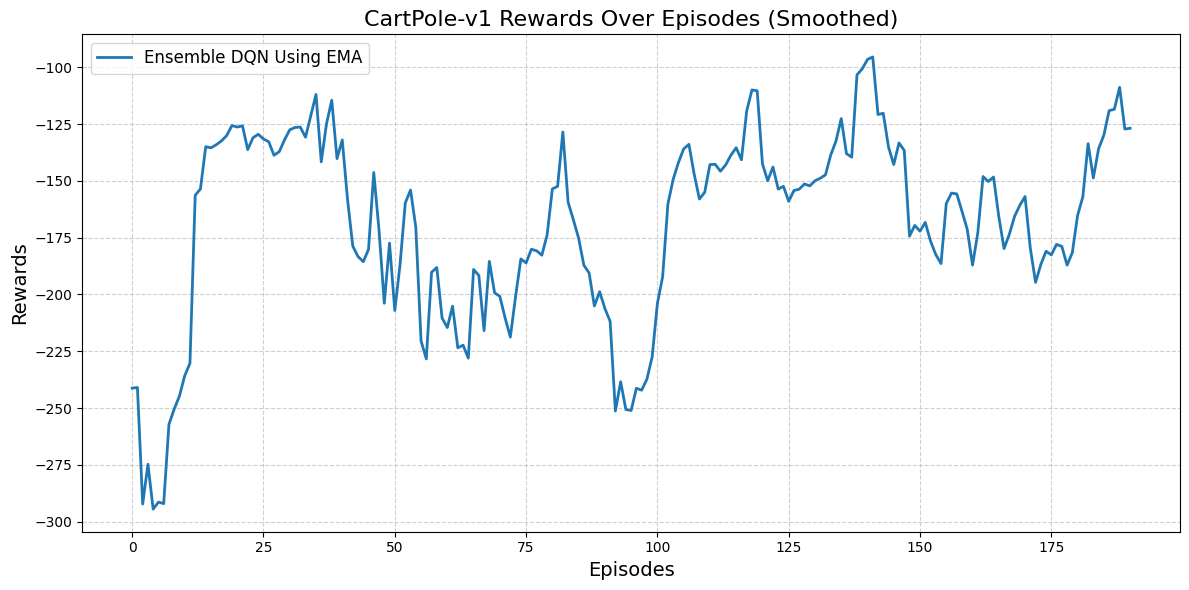

In [154]:
GAMMA = 0.99
BATCH_SIZE = 32
num_episodes = 200
TAU = 0.005  # for soft update
env = gym.make("CartPole-v1")
env = gym.make("LunarLander-v3")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

num_ensemble = 5
online_ensemble = EnsembleDQN(state_dim, action_dim, num_ensemble=num_ensemble, hidden_dim=128)
target_ensemble = EnsembleDQN(state_dim, action_dim, num_ensemble=num_ensemble, hidden_dim=128)
# Initialize target networks to online networks
hard_target_update(online_ensemble, target_ensemble)

# Create one optimizer per ensemble member.
optimizers = [optim.Adam(qnet.parameters(), lr=1e-3) for qnet in online_ensemble.qnets]

replay_buffer = ReplayBuffer(capacity=100000)

model_weights = []

epsilon = 0.1
episode_rewards = []

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    truncated = False
    total_reward = 0
    
    
    while not (done or truncated):
        action = select_action_majority_vote(state, online_ensemble, epsilon, action_dim)
        next_state, reward, done, truncated, _= env.step(action)
        total_reward += reward
        
        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        
        if len(replay_buffer) > BATCH_SIZE:
            
           
            batch = replay_buffer.sample(BATCH_SIZE)
            loss = compute_td_loss_ensemble2(batch, online_ensemble, target_ensemble, optimizers)
            # Optionally print the loss occasionally
            # print(f"Loss: {loss:.4f}")
            
            # Soft-update the target networks
            soft_update(target_ensemble, online_ensemble, TAU)
    
    episode_rewards.append(total_reward)
    print(f"Episode: {episode+1}, Reward: {total_reward:.2f}")

# Plot rewards over episodes
plot_improved_rewards({"Ensemble DQN Using EMA": episode_rewards}, smoothing_window=10, game="CartPole-v1")

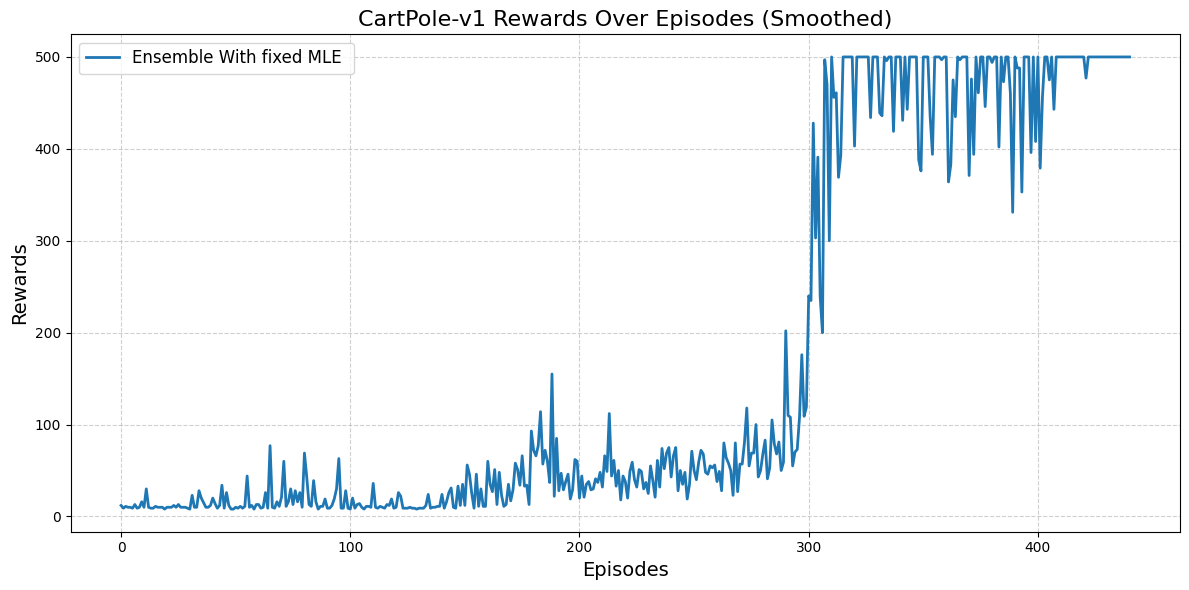

In [147]:
plot_improved_rewards({"Ensemble With fixed MLE ": episode_rewards}, smoothing_window=1, game="CartPole-v1")

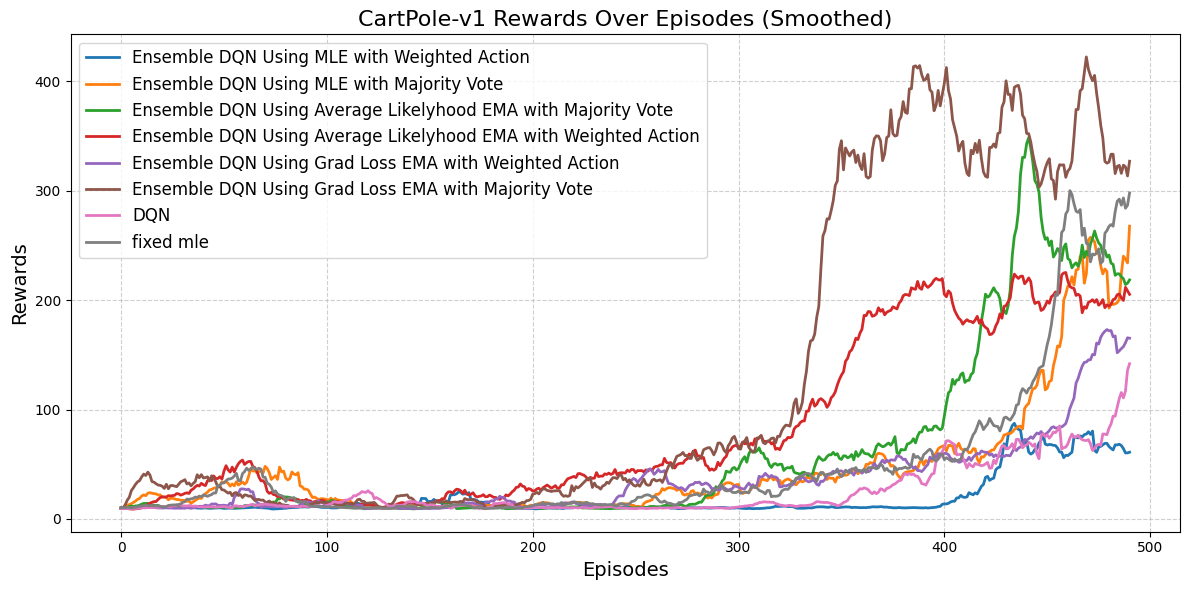

In [66]:
plot_improved_rewards(d, smoothing_window=10, game="CartPole-v1")

In [21]:
d ={}

In [144]:
#d["fixed mle"] = episode_rewards
online_ensemble.possibility



## hasve the case where the possiblity is always 1 

## two critic networks works 

[0.9056417361627432,
 0.9056135429607141,
 1.0,
 0.9861906254310656,
 0.909877617389614]

In [94]:
s, _, _, _, _  = replay_buffer.sample(10)
s = torch.tensor(s)

In [95]:
[
                target_ensemble.qnets[i](torch.tensor(s)).max(dim=1, keepdim=True)[0]
                for i in range(target_ensemble.num_ensemble)
            ]

/var/folders/dm/bf8cjc0d25n75cy02jj4ms940000gn/T/ipykernel_66646/2737501860.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ensemble.qnets[i](torch.tensor(s)).max(dim=1, keepdim=True)[0]


[tensor([[2.8884],
         [2.3193],
         [2.1487],
         [2.2755],
         [2.2535],
         [1.9513],
         [2.2505],
         [2.0597],
         [2.0454],
         [2.6574]], grad_fn=<MaxBackward0>),
 tensor([[2.8781],
         [2.3375],
         [2.1974],
         [2.2865],
         [2.2653],
         [2.0900],
         [2.2672],
         [2.1525],
         [2.1475],
         [2.6629]], grad_fn=<MaxBackward0>),
 tensor([[2.9226],
         [2.3628],
         [2.2102],
         [2.3212],
         [2.3024],
         [2.0559],
         [2.3054],
         [2.1335],
         [2.1215],
         [2.6590]], grad_fn=<MaxBackward0>),
 tensor([[2.9341],
         [2.3388],
         [2.1668],
         [2.3022],
         [2.2758],
         [2.0472],
         [2.2788],
         [2.1126],
         [2.1098],
         [2.6792]], grad_fn=<MaxBackward0>),
 tensor([[2.9123],
         [2.3451],
         [2.1724],
         [2.2857],
         [2.2692],
         [2.0288],
         [2.2704],
   

In [97]:
target_ensemble.qnets[1](torch.tensor(s)).max(dim=1, keepdim=True)[0]

/var/folders/dm/bf8cjc0d25n75cy02jj4ms940000gn/T/ipykernel_66646/2385433367.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ensemble.qnets[1](torch.tensor(s)).max(dim=1, keepdim=True)[0]


tensor([[2.8781],
        [2.3375],
        [2.1974],
        [2.2865],
        [2.2653],
        [2.0900],
        [2.2672],
        [2.1525],
        [2.1475],
        [2.6629]], grad_fn=<MaxBackward0>)

In [98]:
torch.stack([
                target_ensemble.qnets[i](torch.tensor(s)).max(dim=1, keepdim=True)[0]
                for i in range(target_ensemble.num_ensemble)
            ])

/var/folders/dm/bf8cjc0d25n75cy02jj4ms940000gn/T/ipykernel_66646/3837719048.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ensemble.qnets[i](torch.tensor(s)).max(dim=1, keepdim=True)[0]


tensor([[[2.8884],
         [2.3193],
         [2.1487],
         [2.2755],
         [2.2535],
         [1.9513],
         [2.2505],
         [2.0597],
         [2.0454],
         [2.6574]],

        [[2.8781],
         [2.3375],
         [2.1974],
         [2.2865],
         [2.2653],
         [2.0900],
         [2.2672],
         [2.1525],
         [2.1475],
         [2.6629]],

        [[2.9226],
         [2.3628],
         [2.2102],
         [2.3212],
         [2.3024],
         [2.0559],
         [2.3054],
         [2.1335],
         [2.1215],
         [2.6590]],

        [[2.9341],
         [2.3388],
         [2.1668],
         [2.3022],
         [2.2758],
         [2.0472],
         [2.2788],
         [2.1126],
         [2.1098],
         [2.6792]],

        [[2.9123],
         [2.3451],
         [2.1724],
         [2.2857],
         [2.2692],
         [2.0288],
         [2.2704],
         [2.0881],
         [2.0943],
         [2.6646]]], grad_fn=<StackBackward0>)

In [101]:
torch.amin(
            torch.stack([
                target_ensemble.qnets[i](torch.tensor(s)).max(dim=1, keepdim=True)[0]
                for i in range(target_ensemble.num_ensemble)
            ]), dim = 0
        )

/var/folders/dm/bf8cjc0d25n75cy02jj4ms940000gn/T/ipykernel_66646/2706558852.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ensemble.qnets[i](torch.tensor(s)).max(dim=1, keepdim=True)[0]


tensor([[2.8781],
        [2.3193],
        [2.1487],
        [2.2755],
        [2.2535],
        [1.9513],
        [2.2505],
        [2.0597],
        [2.0454],
        [2.6574]], grad_fn=<AminBackward0>)

In [100]:
import torch

# Example tensor of shape [2, 10, 1]
q_values = torch.tensor([[[2.8884],
                          [2.3193],
                          [2.1487],
                          [2.2755],
                          [2.2535],
                          [1.9513],
                          [2.2505],
                          [2.0597],
                          [2.0454],
                          [2.6574]],

                         [[2.8781],
                          [2.3375],
                          [2.1974],
                          [2.2865],
                          [2.2653],
                          [2.0900],
                          [2.2672],
                          [2.1525],
                          [2.1475],
                          [2.6629]]])

# Compute element-wise min across the first dimension (ensemble dimension)
min_q_values = torch.amin(q_values, dim=0)  # Shape: [10, 1]

# Alternative using torch.min()
min_q_values_alt, _ = torch.min(q_values, dim=0)  # Also returns indices, we ignore them

# Output
print("Element-wise Min Q-values:")
print(min_q_values)


Element-wise Min Q-values:
tensor([[2.8781],
        [2.3193],
        [2.1487],
        [2.2755],
        [2.2535],
        [1.9513],
        [2.2505],
        [2.0597],
        [2.0454],
        [2.6574]])


In [128]:
for episode in range(num_episodes):
    state, info = env.reset()
    done = False
    total_reward = 0
    
    
    while not done:
        action = select_action_weighted_sum(state, online_ensemble, epsilon, action_dim)
        next_state, reward, done, truncated, _= env.step(action)
        total_reward += reward
        
        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        
        if len(replay_buffer) > BATCH_SIZE:
            
           
            batch = replay_buffer.sample(BATCH_SIZE)
            loss = compute_td_loss_ensemble(batch, online_ensemble, target_ensemble, optimizers)
            # Optionally print the loss occasionally
            # print(f"Loss: {loss:.4f}")
            
            # Soft-update the target networks
            soft_update(target_ensemble, online_ensemble, TAU)
    
    episode_rewards.append(total_reward)
    print(f"Episode: {episode+1}, Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")

# Plot rewards over episodes
plot_improved_rewards({"Ensemble DQN Using EMA": episode_rewards}, smoothing_window=10, game="CartPole-v1")

Episode: 1, Reward: 252.00, Epsilon: 0.100
Episode: 2, Reward: 256.00, Epsilon: 0.100
Episode: 3, Reward: 260.00, Epsilon: 0.100
Episode: 4, Reward: 249.00, Epsilon: 0.100
Episode: 5, Reward: 278.00, Epsilon: 0.100
Episode: 6, Reward: 263.00, Epsilon: 0.100
Episode: 7, Reward: 273.00, Epsilon: 0.100
Episode: 8, Reward: 80667.00, Epsilon: 0.100
Episode: 9, Reward: 356.00, Epsilon: 0.100
Episode: 10, Reward: 721.00, Epsilon: 0.100
Episode: 11, Reward: 410.00, Epsilon: 0.100
Episode: 12, Reward: 507.00, Epsilon: 0.100
Episode: 13, Reward: 361.00, Epsilon: 0.100
Episode: 14, Reward: 308.00, Epsilon: 0.100
Episode: 15, Reward: 386.00, Epsilon: 0.100
Episode: 16, Reward: 552.00, Epsilon: 0.100
Episode: 17, Reward: 846.00, Epsilon: 0.100
Episode: 18, Reward: 584.00, Epsilon: 0.100
Episode: 19, Reward: 1075.00, Epsilon: 0.100
Episode: 20, Reward: 1765.00, Epsilon: 0.100
Episode: 21, Reward: 4705.00, Epsilon: 0.100
Episode: 22, Reward: 2495.00, Epsilon: 0.100
Episode: 23, Reward: 2707.00, Epsil

KeyboardInterrupt: 

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from collections import deque

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------------------------
# 1. Replay Buffer for Experience Storage
# ---------------------------------------------------------
class ReplayBuffer:
    def __init__(self, max_size=1000000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, state, action, reward, next_state, done):
        # States and actions are stored as numpy arrays.
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones
    
    def size(self):
        return len(self.buffer)

# ---------------------------------------------------------
# 2. Network Architectures
# ---------------------------------------------------------
# For HalfCheetah-v2, we use the observation and action dimensions from gym.
# Typically, HalfCheetah-v2 has state_dim=17 and action_dim=6.

# Actor: Maps state to an action.
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        # Use tanh so that the action output is in [-1, 1]
        action = torch.tanh(self.fc3(x))
        return action

# Critic: Maps a (state, action) pair to a Q-value.
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
    
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q_value = self.fc3(x)
        return q_value

# QuantileModel: Predicts a correction (delta) that is added to the current state 
# to estimate the next state. We use two networks:
#  - One for the lower quantile (e.g., 5th percentile)
#  - One for the upper quantile (e.g., 95th percentile)
class QuantileModel(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(QuantileModel, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, state_dim)  # output dimension = state dimension
    
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        delta = self.fc3(x)
        # Predicted next state is current state plus the delta.
        next_state_pred = state + delta
        return next_state_pred

# ---------------------------------------------------------
# 3. Helper Functions
# ---------------------------------------------------------
def quantile_loss(pred, target, tau):
    """Computes the pinball (quantile) loss."""
    error = target - pred
    loss = torch.max((tau - 1) * error, tau * error)
    return loss.mean()

def sample_candidates(lower, upper, num_samples):
    """
    Uniformly sample candidate next states from the interval [lower, upper].
    - lower, upper: Tensors of shape [batch_size, state_dim]
    - Returns: Tensor of shape [batch_size, num_samples, state_dim]
    """
    batch_size, state_dim = lower.shape
    uniform_samples = torch.rand(batch_size, num_samples, state_dim, device=lower.device)
    candidates = lower.unsqueeze(1) + (upper - lower).unsqueeze(1) * uniform_samples
    return candidates

# ---------------------------------------------------------
# 4. Initialize Environment and Networks
# ---------------------------------------------------------
env = gym.make("HalfCheetah-v5")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

# Initialize networks and move them to the appropriate device.
actor = Actor(state_dim, action_dim).to(device)
critic = Critic(state_dim, action_dim).to(device)
target_actor = Actor(state_dim, action_dim).to(device)
target_critic = Critic(state_dim, action_dim).to(device)
target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())

# Two quantile networks: one for lower bound and one for upper bound prediction.
quantile_lower = QuantileModel(state_dim, action_dim).to(device)
quantile_upper = QuantileModel(state_dim, action_dim).to(device)

# ---------------------------------------------------------
# 5. Optimizers and Hyperparameters
# ---------------------------------------------------------
actor_optimizer = optim.Adam(actor.parameters(), lr=3e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=3e-4)
quantile_lower_optimizer = optim.Adam(quantile_lower.parameters(), lr=3e-4)
quantile_upper_optimizer = optim.Adam(quantile_upper.parameters(), lr=3e-4)

gamma = 0.99
batch_size = 256
num_candidate_samples = 10  # Increase the number of candidate samples
tau_target = 0.005  # Soft update rate for target networks

# ---------------------------------------------------------
# 6. Replay Buffer and Initial Data Collection
# ---------------------------------------------------------
replay_buffer = ReplayBuffer(max_size=1000000)

# Initial random rollout to fill the replay buffer.
num_initial_rollouts = 10000
for _ in range(num_initial_rollouts):
    state = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()  # random action for exploration
        next_state, reward, done, truncated,  _ = env.step(action)
        replay_buffer.add(state, action, reward, next_state, done)
        state = next_state

# ---------------------------------------------------------
# 7. Training Loop: Possibilistic Q-Learning with Quantile Backup
# ---------------------------------------------------------
num_iterations = 100000  # Total training iterations

for it in range(num_iterations):
    if replay_buffer.size() < batch_size:
        continue

    # Sample a mini-batch from the replay buffer.
    states_np, actions_np, rewards_np, next_states_np, dones_np = replay_buffer.sample(batch_size)
    
    # Convert to tensors and move to device.
    states = torch.FloatTensor(states_np).to(device)
    actions = torch.FloatTensor(actions_np).to(device)
    rewards = torch.FloatTensor(rewards_np).unsqueeze(1).to(device)
    next_states = torch.FloatTensor(next_states_np).to(device)
    dones = torch.FloatTensor(dones_np).unsqueeze(1).to(device)
    
    # ----- Update Quantile Models -----
    # The quantile models predict lower and upper bounds for the next state.
    pred_next_lower = quantile_lower(states, actions)
    pred_next_upper = quantile_upper(states, actions)
    
    loss_lower = quantile_loss(pred_next_lower, next_states, tau=0.05)
    loss_upper = quantile_loss(pred_next_upper, next_states, tau=0.95)
    
    quantile_lower_optimizer.zero_grad()
    loss_lower.backward()
    quantile_lower_optimizer.step()
    
    quantile_upper_optimizer.zero_grad()
    loss_upper.backward()
    quantile_upper_optimizer.step()
    
    # ----- Possibilistic Backup via Candidate Sampling -----
    # Use the interval [pred_next_lower, pred_next_upper] as a possibility set.
    candidate_next_states = sample_candidates(pred_next_lower, pred_next_upper, num_candidate_samples)
    # candidate_next_states: [batch_size, num_candidate_samples, state_dim]
    
    # Evaluate each candidate using the target networks.
    bs, num_samples, _ = candidate_next_states.shape
    candidate_next_states_flat = candidate_next_states.reshape(bs * num_samples, state_dim)
    candidate_actions = target_actor(candidate_next_states_flat)
    candidate_qs = target_critic(candidate_next_states_flat, candidate_actions)
    candidate_qs = candidate_qs.reshape(bs, num_samples, 1)
    
    # Also include the actual observed next state as a candidate.
    true_next_state = next_states.unsqueeze(1)  # [batch_size, 1, state_dim]
    true_action = target_actor(next_states)
    true_q = target_critic(next_states, true_action).unsqueeze(1)  # [batch_size, 1, 1]
    
    # Concatenate candidate Q-values.
    all_candidate_qs = torch.cat([candidate_qs, true_q], dim=1)  # [batch_size, num_candidate_samples+1, 1]
    
    # Select the maximum Q-value (optimistic backup).
    max_q, _ = torch.max(all_candidate_qs, dim=1)  # shape: [batch_size, 1]
    target_q = rewards + gamma * (1 - dones) * max_q.detach()
    
    # ----- Update Critic -----
    current_q = critic(states, actions)
    critic_loss = F.mse_loss(current_q, target_q)
    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()
    
    # ----- Update Actor -----
    actor_loss = -critic(states, actor(states)).mean()
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()
    
    # ----- Soft Update of Target Networks -----
    for target_param, param in zip(target_critic.parameters(), critic.parameters()):
        target_param.data.copy_(tau_target * param.data + (1 - tau_target) * target_param.data)
    for target_param, param in zip(target_actor.parameters(), actor.parameters()):
        target_param.data.copy_(tau_target * param.data + (1 - tau_target) * target_param.data)
    
    # Logging every 1000 iterations.
    if it % 1000 == 0:
        print(f"Iter {it}: Critic Loss={critic_loss.item():.4f}, Actor Loss={actor_loss.item():.4f}, "
              f"Quantile Lower Loss={loss_lower.item():.4f}, Quantile Upper Loss={loss_upper.item():.4f}")

# Optionally, save models after training.
torch.save(actor.state_dict(), "halfcheetah_actor.pth")
torch.save(critic.state_dict(), "halfcheetah_critic.pth")


In [22]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from collections import deque

device = "cpu"

class ReplayBuffer:
    def __init__(self, max_size=1000000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, state, action, reward, next_state, done):
        # States and actions are stored as numpy arrays.
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones
    
    def size(self):
        return len(self.buffer)

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        # Use tanh so that the action output is in [-1, 1]
        action = torch.tanh(self.fc3(x))
        return action

# Critic: Maps a (state, action) pair to a Q-value.
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
    
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q_value = self.fc3(x)
        return q_value


class QuantileModel(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(QuantileModel, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, state_dim)  # output dimension = state dimension
    
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        delta = self.fc3(x)
        # Predicted next state is current state plus the learned delta.
        next_state_pred = state + delta
        return next_state_pred


def quantile_loss(pred, target, tau):
    error = target - pred
    loss = torch.max((tau - 1) * error, tau * error)
    return loss.mean()

def sample_candidates(lower, upper, num_samples):
    """
    Uniformly sample candidate next states from the interval [lower, upper].
    - lower, upper: Tensors of shape [batch_size, state_dim]
    - Returns: Tensor of shape [batch_size, num_samples, state_dim]
    """
    batch_size, state_dim = lower.shape
    uniform_samples = torch.rand(batch_size, num_samples, state_dim, device=lower.device)
    candidates = lower.unsqueeze(1) + (upper - lower).unsqueeze(1) * uniform_samples
    return candidates

# ---------------------------------------------------------
# 4. Initialize Environment and Networks
# ---------------------------------------------------------
env = gym.make("HalfCheetah-v5")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]


actor = Actor(state_dim, action_dim).to(device)
critic = Critic(state_dim, action_dim).to(device)
target_actor = Actor(state_dim, action_dim).to(device)
target_critic = Critic(state_dim, action_dim).to(device)
target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())

# Two quantile networks: one for lower bound and one for upper bound.
quantile_lower = QuantileModel(state_dim, action_dim).to(device)
quantile_upper = QuantileModel(state_dim, action_dim).to(device)

actor_optimizer = optim.Adam(actor.parameters(), lr=3e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=3e-4)
quantile_lower_optimizer = optim.Adam(quantile_lower.parameters(), lr=3e-4)
quantile_upper_optimizer = optim.Adam(quantile_upper.parameters(), lr=3e-4)

gamma = 0.99
batch_size = 256
num_candidate_samples = 10  # Number of candidates sampled from the learned interval
tau_target = 0.005  # Soft update rate for target networks

replay_buffer = ReplayBuffer(max_size=1000000)

# Initial random rollout to fill the replay buffer.
num_initial_rollouts = 10000
print("Collecting initial random experience...")
for _ in range(num_initial_rollouts):
    state, _ = env.reset()
    done = False

    action = env.action_space.sample()  # random action for exploration
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    replay_buffer.add(state, action, reward, next_state, done)
    state = next_state


# ---------------------------------------------------------
# 7. Training Loop with Episodes
# ---------------------------------------------------------
num_episodes = 1000
max_episode_steps = 100  # Maximum steps per episode
updates_per_episode = 50  # Number of training updates after each episode

for ep in range(num_episodes):
    state, _ = env.reset()
    episode_reward = 0
    for t in range(max_episode_steps):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = actor(state_tensor).cpu().data.numpy()[0]
        action = action + np.random.normal(0, 0.5, size=action_dim)
        action = np.clip(action, -1, 1)
        
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward
        
        # Store transition in replay buffer.
        replay_buffer.add(state, action, reward, next_state, done)
        
        state = next_state
        if done:
            break
    
    print(f"Episode {ep}: Reward = {episode_reward:.2f}")
    
    
    for _ in range(updates_per_episode):
        if replay_buffer.size() < batch_size:
            continue
        

        states_np, actions_np, rewards_np, next_states_np, dones_np = replay_buffer.sample(batch_size)
        states = torch.FloatTensor(states_np).to(device)
        actions = torch.FloatTensor(actions_np).to(device)
        rewards = torch.FloatTensor(rewards_np).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states_np).to(device)
        dones = torch.FloatTensor(dones_np).unsqueeze(1).to(device)
        

        pred_next_lower = quantile_lower(states, actions)
        pred_next_upper = quantile_upper(states, actions)
        loss_lower = quantile_loss(pred_next_lower, next_states, tau=0.5)
        loss_upper = quantile_loss(pred_next_upper, next_states, tau=0.5)
        
        quantile_lower_optimizer.zero_grad()
        loss_lower.backward()
        quantile_lower_optimizer.step()
        
        quantile_upper_optimizer.zero_grad()
        loss_upper.backward()
        quantile_upper_optimizer.step()
        

        candidate_next_states = sample_candidates(pred_next_lower, pred_next_upper, 10)
        bs, num_samples, _ = candidate_next_states.shape
        candidate_next_states_flat = candidate_next_states.reshape(bs * num_samples, state_dim)
        candidate_actions = target_actor(candidate_next_states_flat)
        candidate_qs = target_critic(candidate_next_states_flat, candidate_actions)
        candidate_qs = candidate_qs.reshape(bs, num_samples, 1)
        
        # Include the true observed next state as a candidate.
        true_next_state = next_states.unsqueeze(1)
        true_action = target_actor(next_states)
        true_q = target_critic(next_states, true_action).unsqueeze(1)
        all_candidate_qs = torch.cat([candidate_qs, true_q], dim=1)
        
        # Select the maximum Q-value (optimistic backup).
        max_q, _ = torch.max(all_candidate_qs, dim=1)
        target_q = rewards + gamma * (1 - dones) * max_q.detach()
        
        # ----- Update Critic -----
        current_q = critic(states, actions)
        critic_loss = F.mse_loss(current_q, target_q)
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()
        
     
        actor_loss = -critic(states, actor(states)).mean()
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()
        for target_param, param in zip(target_critic.parameters(), critic.parameters()):
            target_param.data.copy_(tau_target * param.data + (1 - tau_target) * target_param.data)
        for target_param, param in zip(target_actor.parameters(), actor.parameters()):
            target_param.data.copy_(tau_target * param.data + (1 - tau_target) * target_param.data)
    



Episode 0: Reward = -36.31
Episode 1: Reward = -29.45
Episode 2: Reward = -32.92
Episode 3: Reward = -35.44
Episode 4: Reward = -37.00
Episode 5: Reward = -41.43
Episode 6: Reward = -37.57
Episode 7: Reward = -33.57
Episode 8: Reward = -38.01
Episode 9: Reward = -32.83
Episode 10: Reward = -36.25
Episode 11: Reward = -35.83
Episode 12: Reward = -41.73
Episode 13: Reward = -43.28
Episode 14: Reward = -43.89
Episode 15: Reward = -40.48
Episode 16: Reward = -39.27
Episode 17: Reward = -42.80
Episode 18: Reward = -40.39
Episode 19: Reward = -27.92
Episode 20: Reward = -47.83
Episode 21: Reward = -43.91
Episode 22: Reward = -27.77
Episode 23: Reward = -9.79
Episode 24: Reward = -50.04
Episode 25: Reward = -39.44
Episode 26: Reward = -21.25
Episode 27: Reward = -37.82
Episode 28: Reward = -27.18
Episode 29: Reward = -10.51
Episode 30: Reward = -28.73
Episode 31: Reward = -40.26
Episode 32: Reward = -42.79
Episode 33: Reward = -33.95
Episode 34: Reward = -44.54
Episode 35: Reward = -46.95
Epi

KeyboardInterrupt: 

In [23]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from collections import deque

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------------------------
# 1. Replay Buffer for Experience Storage
# ---------------------------------------------------------
class ReplayBuffer:
    def __init__(self, max_size=1000000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones
    
    def size(self):
        return len(self.buffer)

# ---------------------------------------------------------
# 2. Network Architectures for a Simple Actor-Critic
# ---------------------------------------------------------
# For HalfCheetah-v5, typically state_dim ≈ 17 and action_dim ≈ 6.

# Actor: Maps a state to an action.
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        # tanh squashes the output to [-1, 1]
        action = torch.tanh(self.fc3(x))
        return action

# Critic: Maps a (state, action) pair to a scalar Q-value.
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
    
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q_value = self.fc3(x)
        return q_value

# ---------------------------------------------------------
# 3. Initialize Environment and Networks
# ---------------------------------------------------------
env = gym.make("HalfCheetah-v5")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

actor = Actor(state_dim, action_dim).to(device)
critic = Critic(state_dim, action_dim).to(device)
target_actor = Actor(state_dim, action_dim).to(device)
target_critic = Critic(state_dim, action_dim).to(device)
target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())

# ---------------------------------------------------------
# 4. Optimizers and Hyperparameters
# ---------------------------------------------------------
actor_optimizer = optim.Adam(actor.parameters(), lr=3e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=3e-4)
gamma = 0.99
batch_size = 256
tau_target = 0.005  # Soft update rate for target networks

# ---------------------------------------------------------
# 5. Replay Buffer and Initial Data Collection
# ---------------------------------------------------------
replay_buffer = ReplayBuffer(max_size=1000000)

# Collect initial random experience to fill the replay buffer.
num_initial_rollouts = 10000
print("Collecting initial random experience...")
for _ in range(num_initial_rollouts):
    state, _ = env.reset()
    done = False
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    replay_buffer.add(state, action, reward, next_state, done)
    state = next_state

# ---------------------------------------------------------
# 6. Training Loop with Episodes
# ---------------------------------------------------------
num_episodes = 1000
max_episode_steps = 1000  # Maximum steps per episode
updates_per_episode = 50  # Number of training updates after each episode

for ep in range(num_episodes):
    state, _ = env.reset()
    episode_reward = 0
    for t in range(max_episode_steps):
        # Convert state to tensor and select action using the actor network.
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = actor(state_tensor).cpu().data.numpy()[0]
        # Add Gaussian exploration noise.
        action = action + np.random.normal(0, 0.1, size=action_dim)
        action = np.clip(action, -1, 1)
        
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward
        
        replay_buffer.add(state, action, reward, next_state, done)
        state = next_state
        
        if done:
            break
    
    print(f"Episode {ep}: Reward = {episode_reward:.2f}")
    
    # Perform several training updates after each episode.
    for _ in range(updates_per_episode):
        if replay_buffer.size() < batch_size:
            continue
        
        # Sample a mini-batch from the replay buffer.
        states_np, actions_np, rewards_np, next_states_np, dones_np = replay_buffer.sample(batch_size)
        states = torch.FloatTensor(states_np).to(device)
        actions = torch.FloatTensor(actions_np).to(device)
        rewards = torch.FloatTensor(rewards_np).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states_np).to(device)
        dones = torch.FloatTensor(dones_np).unsqueeze(1).to(device)
        
        # Compute the target Q-value using the target networks.
        next_actions = target_actor(next_states)
        next_q = target_critic(next_states, next_actions)
        target_q = rewards + gamma * (1 - dones) * next_q.detach()
        
        # Critic update: minimize the MSE between current Q and target Q.
        current_q = critic(states, actions)
        critic_loss = F.mse_loss(current_q, target_q)
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()
        
        # Actor update: maximize the Q-value by minimizing the negative Q.
        actor_loss = -critic(states, actor(states)).mean()
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()
        
        # Soft update of the target networks.
        for target_param, param in zip(target_critic.parameters(), critic.parameters()):
            target_param.data.copy_(tau_target * param.data + (1 - tau_target) * target_param.data)
        for target_param, param in zip(target_actor.parameters(), actor.parameters()):
            target_param.data.copy_(tau_target * param.data + (1 - tau_target) * target_param.data)
    
    # Save checkpoints periodically.
    if ep % 100 == 0:
        torch.save(actor.state_dict(), f"simple_actor_ep{ep}.pth")
        torch.save(critic.state_dict(), f"simple_critic_ep{ep}.pth")


Episode 0: Reward = -8.42
Episode 1: Reward = -366.94
Episode 2: Reward = -394.09
Episode 3: Reward = -348.60
Episode 4: Reward = -291.66
Episode 5: Reward = -506.58
Episode 6: Reward = -598.18
Episode 7: Reward = -279.03
Episode 8: Reward = -267.15
Episode 9: Reward = -262.92
Episode 10: Reward = -224.33
Episode 11: Reward = -231.45
Episode 12: Reward = -213.06
Episode 13: Reward = -231.86
Episode 14: Reward = -234.14
Episode 15: Reward = -248.80
Episode 16: Reward = -238.51
Episode 17: Reward = -234.94
Episode 18: Reward = -238.58
Episode 19: Reward = -229.42
Episode 20: Reward = -224.81
Episode 21: Reward = -226.42
Episode 22: Reward = -237.04
Episode 23: Reward = -226.99
Episode 24: Reward = -238.31
Episode 25: Reward = -395.37
Episode 26: Reward = -264.08
Episode 27: Reward = -216.15
Episode 28: Reward = -191.79
Episode 29: Reward = -165.21
Episode 30: Reward = -212.42
Episode 31: Reward = -161.11
Episode 32: Reward = -146.57
Episode 33: Reward = -152.29
Episode 34: Reward = -160.

In [14]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from collections import deque

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------------------------
# 1. Replay Buffer for Experience Storage
# ---------------------------------------------------------
class ReplayBuffer:
    def __init__(self, max_size=1000000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones
    
    def size(self):
        return len(self.buffer)

# ---------------------------------------------------------
# 2. Network Architectures
# ---------------------------------------------------------
# For HalfCheetah-v5, the observation space typically has dimension 17 and the action space 6.

# Actor: Maps state to an action.
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        action = torch.tanh(self.fc3(x))
        return action

# Critic: Maps a (state, action) pair to a Q-value.
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
    
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q_value = self.fc3(x)
        return q_value

# QuantileModel: Predicts a correction (delta) that added to the current state yields an estimate of the next state.
class QuantileModel(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(QuantileModel, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, state_dim)
    
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        delta = self.fc3(x)
        next_state_pred = state + delta
        return next_state_pred

# ---------------------------------------------------------
# 3. Helper Functions
# ---------------------------------------------------------
def quantile_loss(pred, target, tau):
    error = target - pred
    loss = torch.max((tau - 1) * error, tau * error)
    return loss.mean()

def sample_candidates(lower, upper, num_samples):
    batch_size, state_dim = lower.shape
    uniform_samples = torch.rand(batch_size, num_samples, state_dim, device=lower.device)
    candidates = lower.unsqueeze(1) + (upper - lower).unsqueeze(1) * uniform_samples
    return candidates

# ---------------------------------------------------------
# 4. Initialize Environment and Networks
# ---------------------------------------------------------
env = gym.make("HalfCheetah-v5")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

actor = Actor(state_dim, action_dim).to(device)
critic = Critic(state_dim, action_dim).to(device)
target_actor = Actor(state_dim, action_dim).to(device)
target_critic = Critic(state_dim, action_dim).to(device)
target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())

quantile_lower = QuantileModel(state_dim, action_dim).to(device)
quantile_upper = QuantileModel(state_dim, action_dim).to(device)

# ---------------------------------------------------------
# 5. Optimizers and Hyperparameters
# ---------------------------------------------------------
actor_optimizer = optim.Adam(actor.parameters(), lr=3e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=3e-4)
quantile_lower_optimizer = optim.Adam(quantile_lower.parameters(), lr=3e-4)
quantile_upper_optimizer = optim.Adam(quantile_upper.parameters(), lr=3e-4)

gamma = 0.99
batch_size = 256
num_candidate_samples = 10
tau_target = 0.005

# New hyperparameters for improvements:
critic_updates_per_actor_update = 10
reward_shift = 10.0  # shift negative rewards upward

# ---------------------------------------------------------
# 6. Replay Buffer and Initial Data Collection
# ---------------------------------------------------------
replay_buffer = ReplayBuffer(max_size=1000000)
num_initial_rollouts = 10000
print("Collecting initial random experience...")
for _ in range(num_initial_rollouts):
    state, _ = env.reset()
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    replay_buffer.add(state, action, reward, next_state, done)
    state = next_state

# ---------------------------------------------------------
# 7. Training Loop with Episodes
# ---------------------------------------------------------
num_episodes = 1000
max_episode_steps = 100  # can be adjusted based on computational budget
updates_per_episode = 50  # total training updates after each episode

for ep in range(num_episodes):
    state, _ = env.reset()
    episode_reward = 0
    for t in range(max_episode_steps):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = actor(state_tensor).cpu().data.numpy()[0]
        action = action + np.random.normal(0, 0.1, size=action_dim)
        action = np.clip(action, -1, 1)
        
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward
        
        replay_buffer.add(state, action, reward, next_state, done)
        state = next_state
        if done:
            break
    
    print(f"Episode {ep}: Reward = {episode_reward:.2f}")
    
    # Improved update: perform several critic/quantile updates for every actor update.
    for update_iter in range(updates_per_episode):
        if replay_buffer.size() < batch_size:
            continue
        
        states_np, actions_np, rewards_np, next_states_np, dones_np = replay_buffer.sample(batch_size)
        states = torch.FloatTensor(states_np).to(device)
        actions = torch.FloatTensor(actions_np).to(device)
        # Apply reward shift
        rewards = torch.FloatTensor(rewards_np).unsqueeze(1).to(device) + reward_shift
        next_states = torch.FloatTensor(next_states_np).to(device)
        dones = torch.FloatTensor(dones_np).unsqueeze(1).to(device)
        
        # ----- Update Quantile Models -----
        pred_next_lower = quantile_lower(states, actions)
        pred_next_upper = quantile_upper(states, actions)
        loss_lower = quantile_loss(pred_next_lower, next_states, tau=0.05)
        loss_upper = quantile_loss(pred_next_upper, next_states, tau=0.95)
        quantile_lower_optimizer.zero_grad()
        loss_lower.backward()
        quantile_lower_optimizer.step()
        quantile_upper_optimizer.zero_grad()
        loss_upper.backward()
        quantile_upper_optimizer.step()
        
        # ----- Possibilistic Backup via Candidate Sampling -----
        candidate_next_states = sample_candidates(pred_next_lower, pred_next_upper, num_candidate_samples)
        bs, num_samples, _ = candidate_next_states.shape
        candidate_next_states_flat = candidate_next_states.reshape(bs * num_samples, state_dim)
        candidate_actions = target_actor(candidate_next_states_flat)
        candidate_qs = target_critic(candidate_next_states_flat, candidate_actions)
        candidate_qs = candidate_qs.reshape(bs, num_samples, 1)
        true_next_state = next_states.unsqueeze(1)
        true_action = target_actor(next_states)
        true_q = target_critic(next_states, true_action).unsqueeze(1)
        all_candidate_qs = torch.cat([candidate_qs, true_q], dim=1)
        max_q, _ = torch.max(all_candidate_qs, dim=1)
        target_q = rewards + gamma * (1 - dones) * max_q.detach()
        
        # ----- Critic Update -----
        current_q = critic(states, actions)
        critic_loss = F.mse_loss(current_q, target_q)
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()
        
        # ----- Delayed Actor Update: update actor only every critic_updates_per_actor_update iterations -----
        if update_iter % critic_updates_per_actor_update == 0:
            actor_loss = -critic(states, actor(states)).mean()
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()
        
        # ----- Soft Update of Target Networks -----
        for target_param, param in zip(target_critic.parameters(), critic.parameters()):
            target_param.data.copy_(tau_target * param.data + (1 - tau_target) * target_param.data)
        for target_param, param in zip(target_actor.parameters(), actor.parameters()):
            target_param.data.copy_(tau_target * param.data + (1 - tau_target) * target_param.data)


Episode 0: Reward = 0.02
Episode 1: Reward = -1.82
Episode 2: Reward = -5.11
Episode 3: Reward = -11.97
Episode 4: Reward = -21.91
Episode 5: Reward = -30.85
Episode 6: Reward = -33.94
Episode 7: Reward = -37.55
Episode 8: Reward = -40.49
Episode 9: Reward = -38.76
Episode 10: Reward = -37.85
Episode 11: Reward = -42.21
Episode 12: Reward = -44.27
Episode 13: Reward = -51.32
Episode 14: Reward = -55.12
Episode 15: Reward = -56.14
Episode 16: Reward = -56.75
Episode 17: Reward = -54.43
Episode 18: Reward = -54.51
Episode 19: Reward = -55.22
Episode 20: Reward = -55.06
Episode 21: Reward = -54.47
Episode 22: Reward = -54.00
Episode 23: Reward = -49.27
Episode 24: Reward = -48.89
Episode 25: Reward = -55.04
Episode 26: Reward = -57.60
Episode 27: Reward = -55.17
Episode 28: Reward = -56.35
Episode 29: Reward = -57.35
Episode 30: Reward = -55.42
Episode 31: Reward = -55.48
Episode 32: Reward = -55.95
Episode 33: Reward = -54.82
Episode 34: Reward = -55.29
Episode 35: Reward = -56.82
Episod

KeyboardInterrupt: 

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from collections import deque
import copy

# ====================================================
# 0. Define a simple Args container for hyperparameters
# ====================================================
class Args:
    def __init__(self):
        # Basic hyperparameters
        self.epsilon = 0.1
        self.lr = 3e-4
        self.tau = 0.005
        self.discount = 0.99
        self.n_ensemble = 5
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.set_init_seed = True
        self.seed = 42

        # Environment dimensions (for HalfCheetah-v5)
        self.state_space = 17   # HalfCheetah-v5 observation dim
        self.action_dim = 6     # HalfCheetah-v5 action dim

        # Quantile network hidden size
        self.quantile_hidden_dim = 256

        # Reward function learning
        self.learn_reward = False  # For simplicity, we disable a learned reward function here.
        self.reward_dependence = "sa"  # or "ns" or "sans", etc.
        self.set_train_seed = True

        # Timesteps: when to start training the forward models / reward function
        self.start_timesteps = 10000
        self.start_fm_timesteps = 10000
        self.start_rf_timesteps = 10000

        # For sampling mini-batches randomly from a subset of the batch.
        self.random_batch = False
        self.mini_size = 50
        
        # Number of candidate samples to draw from quantile bounds.
        self.p_sample_n = 10

        # Which sampling strategy to use.
        self.sample_from_avg = False
        self.sample_from_bound = False

        # Number of critic-only iterations (when updating critic multiple times)
        self.IterOnlyCritic_n = 10

        # For logging purposes (if using wandb)
        self.use_wandb = False
        self.record_one = False

# ====================================================
# 1. Replay Buffer (with getBatch() for compatibility)
# ====================================================
class ReplayBuffer:
    def __init__(self, max_size=1000000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    # getBatch() is equivalent to sample() here.
    def getBatch(self, batch_size):
        return self.sample(batch_size)
    
    def size(self):
        return len(self.buffer)

# ====================================================
# 2. Network Architectures (Actor, Critic, Quantile Models, Reward Function)
# ====================================================
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
    
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.constant_(self.fc3.bias, 0)
    
    def forward(self, state):
        a = F.relu(self.fc1(state))
        a = F.relu(self.fc2(a))
        a = torch.tanh(self.fc3(a))
        return a

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)
    
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

        nn.init.constant_(self.fc1.bias, 0)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.constant_(self.fc3.bias, 0)

    def forward(self, state, action):
        q = torch.cat([state, action], dim=-1)
        q = F.relu(self.fc1(q))
        q = F.relu(self.fc2(q))
        q = self.fc3(q)
        return q

class Quantile_model(nn.Module):
    def __init__(self, state_dim, action_dim, init_type = "xavier", zero_bias = True, Q_hidden_dim = 256):
        super(Quantile_model, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, Q_hidden_dim)
        self.fc2 = nn.Linear(Q_hidden_dim, Q_hidden_dim)
        self.fc3 = nn.Linear(Q_hidden_dim, state_dim)
        
        if init_type == "xavier":
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
            nn.init.xavier_uniform_(self.fc3.weight)
        if zero_bias:
            nn.init.constant_(self.fc1.bias, 0)
            nn.init.constant_(self.fc2.bias, 0)
            nn.init.constant_(self.fc3.bias, 0)
    
    def forward(self, state, action):
        s  = torch.cat([state, action], dim=-1)
        s = F.relu(self.fc1(s))
        s = F.relu(self.fc2(s))
        ds = self.fc3(s)
        x = ds + state
        return x

class Reward_function(nn.Module):
    def __init__(self, input_dim):
        super(Reward_function, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.constant_(self.fc3.bias, 0)
    
    def forward(self, input):
        r = F.relu(self.fc1(input))
        r = F.relu(self.fc2(r))
        r = self.fc3(r)
        return r

# ====================================================
# 3. The MMQ Q–Agent
# ====================================================
class MMQ_Q_Agent():
    def __init__(self, args, id = None):
        self.args = args
        self.epsilon = args.epsilon
        self.lr = args.lr
        self.tau = args.tau
        self.discount = args.discount
        self.n_ensemble = args.n_ensemble
        
        self.device = torch.device(self.args.device)
            
        if self.args.set_init_seed:
            np.random.seed(self.args.seed + (id if id is not None else 0))
            torch.manual_seed(self.args.seed + (id if id is not None else 0))

        self.actor = Actor(args.state_space, args.action_dim).to(self.device)
        self.target_actor = copy.deepcopy(self.actor)
        self.critic = Critic(args.state_space, args.action_dim).to(self.device)
        self.target_critic = copy.deepcopy(self.critic)

        self.forward_model_l = []
        self.forward_model_u = []
        for i in range(self.n_ensemble):
            self.forward_model_l.append(Quantile_model(args.state_space, args.action_dim, Q_hidden_dim=args.quantile_hidden_dim).to(self.device))
            self.forward_model_u.append(Quantile_model(args.state_space, args.action_dim, Q_hidden_dim=args.quantile_hidden_dim).to(self.device))
                
        self.actor_optimizer = optim.Adam(self.actor.parameters(), self.lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), self.lr)

        self.forward_model_optimizer_l = []
        self.forward_model_optimizer_u = []
        for i in range(self.n_ensemble):
            self.forward_model_optimizer_l.append(optim.Adam(self.forward_model_l[i].parameters(), self.lr))
            self.forward_model_optimizer_u.append(optim.Adam(self.forward_model_u[i].parameters(), self.lr))

        self.total_it = 0
        
        if self.args.learn_reward:
            if self.args.reward_dependence == "ns" or self.args.reward_dependence == "s":
                input_dim = self.args.state_space
            elif self.args.reward_dependence == "sans":
                input_dim = self.args.state_space * 2 + self.args.action_dim
            elif self.args.reward_dependence == "sa":
                input_dim = self.args.state_space + self.args.action_dim

            self.reward_function = Reward_function(input_dim).to(self.device)
            self.reward_function_optimizer = optim.Adam(self.reward_function.parameters(), self.lr)

        if self.args.set_train_seed:
            np.random.seed(self.args.seed + (id if id is not None else 0))
            torch.manual_seed(self.args.seed + (id if id is not None else 0))
    
    def select_action(self, state, evaluate, total_step):
        state = torch.FloatTensor(state).to(self.device)
        epsilon = 0 if evaluate else self.args.epsilon
        with torch.no_grad():
            if not evaluate:
                if total_step < self.args.start_timesteps:
                    action = 2 * np.random.rand(self.args.action_dim) - 1
                elif (np.random.uniform() < epsilon):
                    action = 2 * np.random.rand(self.args.action_dim) - 1
                else:
                    action = np.clip(self.actor(state).cpu().data.numpy() + 0.1*np.random.randn(self.args.action_dim), -1, 1)
            else:
                action = self.actor(state).cpu().data.numpy()
        return action
    
    def quantile_loss(self, predictions, targets, tau):
        errors = targets - predictions
        return torch.max((tau-1) * errors, tau * errors).mean()
    
    def sample_ns(self, ls, us):
        z = torch.FloatTensor(np.random.uniform(ls.detach().cpu(), us.detach().cpu(), size=(ls.shape[0], self.args.state_space))).to(self.device)
        return z
                
    def train(self, id, total_steps, buffer, batch_size=100):
    # Get a batch from the replay buffer (numpy arrays)
        states_np, actions_np, rewards_np, next_states_np, dones_np = buffer.getBatch(batch_size)
        
        # Convert numpy arrays to torch tensors and send them to the device
        states = torch.FloatTensor(states_np).to(self.device)
        actions = torch.FloatTensor(actions_np).to(self.device)
        rewards = torch.FloatTensor(rewards_np).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states_np).to(self.device)
        dones = torch.FloatTensor(dones_np).unsqueeze(1).to(self.device)
        
        self.total_it += 1
        
        # Update forward (quantile) models for each ensemble member.
        if total_steps > min(self.args.start_fm_timesteps, self.args.start_timesteps):
            for ee in range(self.n_ensemble):
                L_ns  = self.forward_model_l[ee](states, actions)
                U_ns = self.forward_model_u[ee](states, actions)
                forward_model_loss_l = self.quantile_loss(L_ns, next_states, tau=0.05)
                forward_model_loss_u = self.quantile_loss(U_ns, next_states, tau=0.95)
                self.forward_model_optimizer_l[ee].zero_grad()
                forward_model_loss_l.backward()
                self.forward_model_optimizer_l[ee].step()
    
                self.forward_model_optimizer_u[ee].zero_grad()
                forward_model_loss_u.backward()
                self.forward_model_optimizer_u[ee].step()
   
        
        if total_steps > min(self.args.start_rf_timesteps, self.args.start_timesteps) and self.args.learn_reward:
            if self.args.reward_dependence == "ns":
                input_data = next_states
            elif self.args.reward_dependence == "s":
                input_data = states
            elif self.args.reward_dependence == "sans":
                input_data = torch.cat([states, actions, next_states], dim = -1)
            elif self.args.reward_dependence == "sa":
                input_data = torch.cat([states, actions], dim = -1)
            reward_function_loss = F.mse_loss(self.reward_function(input_data), rewards)
            self.reward_function_optimizer.zero_grad()
            reward_function_loss.backward()
            self.reward_function_optimizer.step()
        
        if total_steps > self.args.start_timesteps:
            actor_loss = -self.critic(states, self.actor(states)).mean()
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
    
            # (For brevity, the rest of the training process involving sampling from quantile models,
            # backup computation, critic updates, and target network updates is omitted here.)
            # In your full implementation, you would include the remaining training steps as in your provided code.
        return

# ====================================================
# 4. Create the Args object and instantiate the agent
# ====================================================
args = Args()
agent = MMQ_Q_Agent(args, id=0)

# ====================================================
# 5. Create a replay buffer
# ====================================================
replay_buffer = ReplayBuffer(max_size=1000000)

# (For simplicity, assume you have a method to collect initial experience; here, we do a short random rollout.)
env = gym.make("HalfCheetah-v5")
num_initial_steps = 10000
print("Collecting initial random experience...")
state, _ = env.reset()
for _ in range(num_initial_steps):
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    replay_buffer.add(state, action, reward, next_state, done)
    state = next_state
    if done:
        state, _ = env.reset()

# ====================================================
# 6. Training Loop for HalfCheetah using the MMQ_Q_Agent
# ====================================================
num_episodes = 1000
max_episode_steps = 1000
total_steps = 0

for ep in range(num_episodes):
    state, _ = env.reset()
    episode_reward = 0
    for t in range(max_episode_steps):
        action = agent.select_action(state, evaluate=False, total_step=total_steps)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward
        replay_buffer.add(state, action, reward, next_state, done)
        state = next_state
        total_steps += 1
        
        # Begin training once enough steps have been collected.
        if total_steps > args.start_timesteps:
            agent.train(id=0, total_steps=total_steps, buffer=replay_buffer, batch_size=256)
        
        if done:
            break
    print(f"Episode {ep}: Reward = {episode_reward:.2f}")

# Optionally, save the final model weights.
agent.save("mmq_halfcheetah_final", agent_idx=0)


Episode 0: Reward = -258.21
Episode 1: Reward = -209.01
Episode 2: Reward = -295.33
Episode 3: Reward = -266.17
Episode 4: Reward = -169.10
Episode 5: Reward = -268.46
Episode 6: Reward = -286.12
Episode 7: Reward = -439.57
Episode 8: Reward = -105.65
Episode 9: Reward = -276.15
Episode 10: Reward = -453.78
Episode 11: Reward = -569.78
